In [115]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

import dgutils
from dgutils import colors as colortools
from numpy import pi as π
from wetting_utils import *
from collections import defaultdict
import matplotlib.transforms as mtransforms
from heprops import helium,potential


%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## Load all the radial density data from disk

In [127]:
L = 25 # Å
r = {}
ϱ = {}
norm = {}

def lab(element,R):
    return f'{element} {R:.1f} Å'

R = np.array([4.0,5.0,6.0,8.0,10.0,12.0])
for el in elements:
    for cR in R:
        with np.load(ψ_filename(cR, el)) as f:
            r[lab(el,cR)] = f['arr_0']
            ϱ[lab(el,cR)] = f['arr_1']
            norm[lab(el,cR)] = normalize_psi_PIMC(ϱ[lab(el,cR)], r[lab(el,cR)])


Norm = 1.9943041040885479
Norm = 2.012019301825279
Norm = 2.024150715245431
Norm = 1.9800310251346966
Norm = 2.1046567393856987
Norm = 1.9415150846487308
Norm = 2.010337365927424
Norm = 1.993634737869944
Norm = 2.0064659361227046
Norm = 2.0067059874964754
Norm = 1.958938157067764
Norm = 2.016635750803403
Norm = 2.0424958295357984
Norm = 2.0093979071313233
Norm = 1.997469735916623
Norm = 1.9989870399327152
Norm = 1.9990406105038216
Norm = 2.0072822408958575
Norm = 2.037814537386417
Norm = 2.006357258683769
Norm = 1.9962150776637035
Norm = 2.0009769953493723
Norm = 2.0028763722857432
Norm = 2.001480704770855
Norm = 1.992071115444631
Norm = 2.0103633590184247
Norm = 2.024917521669982
Norm = 1.94070081596374
Norm = 2.0700241226652607
Norm = 2.0841175412066173
Norm = 2.044911369306078
Norm = 2.0103212191748203
Norm = 1.997519008255205
Norm = 1.9992283248211957
Norm = 2.0000203318148158
Norm = 2.0075648790785547
Norm = 2.010337365927424
Norm = 1.993634737869944
Norm = 2.0064659361227046
Norm

## First we compute the value of $\langle r/R \rangle$ for each element and R

\begin{equation}
    \left \langle {\frac{r}{R}} \right \rangle = \frac{2\pi L}{N R}\int_0^R r^2 d{r} \varrho(r)
\end{equation}


In [128]:
averoR = defaultdict(list)
for el in elements:
    _averoR = []
    for cR in R:
        _r = r[lab(el,cR)]
        _ϱ = ϱ[lab(el,cR)]
        _averoR.append(2*π*L*intgr.simpson(_r*_r*_ρ, _r)/norm[lab(el,cR)]/cR)

    averoR[el] = np.array(_averoR)

## Now we compute the fraction of particles in the well

\begin{equation}
    f_{\text{well}} = \frac{2\pi L}{N} \int_{r_0 - 2r_{\rm He}}^{R} rd{r} \varrho(r)
\end{equation}

In [240]:
rHe = 1.4 # Å

fwell = {}
U_pore_min = {}
for el in elements:
    _fwell = []
    _U_pore_min = []
    for cR in R:

        if el == 'hwall':
            rmin = cR-2*rHe
            _U_pore_min.append(0.0)
        else:
            __r = np.linspace(0,cR-0.1,1000)
            pot = U_pore(__r,cR, ɛ[el], σ[el], n_density[el])
            idx = np.argmin(pot)
            _U_pore_min.append(pot[idx])
            r0 = __r[idx]
            rmin = r0 - 2*rHe
            
        _r = r[lab(el,cR)]
        _ϱ = ϱ[lab(el,cR)]
        min_idx = np.where(_r >= rmin)[0][0]
        
        _fwell.append(2*π*L*intgr.simpson(_r[min_idx:]*_ϱ[min_idx:], _r[min_idx:])/norm[lab(el,cR)])
    fwell[el] = np.array(_fwell)
    U_pore_min[el] = np.array(_U_pore_min)


### Get the energy scale corresponding to the minimum of the He-He interaction potential

In [241]:
V = potential.szalewicz_2012
__r = np.linspace(2.5,5,1000)
V_min = np.min(V(__r))

## Create the Combined Plot

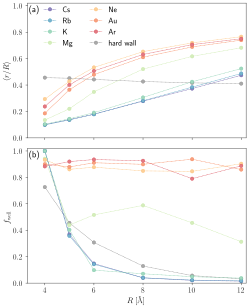

In [242]:
atom_list = ['Cs','Rb','K','Mg','Ne','Au','Ar','hwall']

with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(figsize[0],2*figsize[1]), sharex=True, sharey=True, constrained_layout=True)
    
    for el in atom_list:
        col = element_colors[el]

        zorder = -1 if el == 'hwall' else 0
        elab = el if el != 'hwall' else 'hard wall'

        ax1.plot(R,averoR[el],'o:', label=elab, color=col,zorder=zorder,
                 mfc=colortools.get_alpha_hex(col,0.7), markersize=3.5, linewidth=0.5, mec=col)
        ax2.plot(R,fwell[el],'o:', label=elab, color=col,zorder=zorder,
                 mfc=colortools.get_alpha_hex(col,0.7), markersize=3.5, linewidth=0.5, mec=col)

    ax1.set_ylabel(r'$\langle r/R\rangle$')
    ax2.set_ylabel(r'$f_{\rm well}$')
    ax2.set_xlabel(r'$R \; [\rm \AA]$')
    ax1.set_xlim(3.3,12.2)
    ax2.set_ylim(0,1.02)
    ax1.legend(handlelength=1.5, ncols=2, loc=(0.06,0.65))

    # Add a possible labels
    trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)
    ax1.text(0.0, 1.0, '(a)', transform=ax1.transAxes + trans)
    ax2.text(0.0, 1.0, '(b)', transform=ax2.transAxes + trans)
    plt.savefig('../figures/Wetting-parameters_combined_R.pdf')

## Phase Diagram using $f_{\rm well}$

In [243]:
pd_data = []
for el in elements:
    #if el != 'hwall':    
    for i,cR in enumerate(R):
        pd_data.append([cR,U_pore_min[el][i]/V_min,fwell[el][i]])

pd_data = np.array(pd_data)

### Interoplate on a grid to form the decision boundaries

In [244]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

x = pd_data[:,0]
y = pd_data[:,1]
f = pd_data[:,2]

# The phase cutoffs
a, b, c, d = 0, 0.4, 0.6, 1.   # phase1: a<f<b, phase2: b<f<c, phase3: c<f<d

# Interpolate to grid
nx, ny = 100, 100
xi = np.linspace(R.min()-0.5, R.max()+0.5, nx)
yi = np.linspace(pd_data[:,1].min(), pd_data[:,1].max()+1, ny)
Xi, Yi = np.meshgrid(xi, yi)

Fi_lin = griddata(points=(x,y),values=f, xi=(Xi, Yi),method='linear')

# nearest-neighbor for extrapolation 
Fi_nn  = griddata((x, y), f, (Xi, Yi), method='nearest')

# fill NaNs from linear with nearest (keeps phases unchanged outside)
Fi = np.where(np.isnan(Fi_lin), Fi_nn, Fi_lin)

# Gentle smoothing (comment out if you want raw interpolation)
Fi = gaussian_filter(Fi, sigma=2.5)

# Mask out areas outside convex hull (griddata returns NaN there)
Fi_masked = np.ma.masked_invalid(Fi)

# Discrete phase coloring
cmap = ListedColormap([colortools.get_alpha_hex(element_colors['Cs'],0.35), 
                       colortools.get_alpha_hex(element_colors['Mg'],0.35), 
                       colortools.get_alpha_hex(element_colors['Ar'],0.35)])
bounds = [a, b, c, d]
_norm = BoundaryNorm(bounds, cmap.N)

## The wetting phase diagram

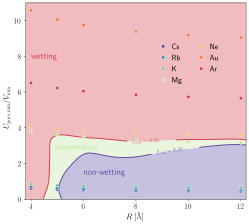

In [245]:
with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig, ax = plt.subplots(constrained_layout=True, figsize=(figsize[0],0.9*figsize[0]))

    # Use contourf for crisp discrete regions
    cf = ax.contourf(Xi, Yi, Fi_masked, levels=bounds, cmap=cmap, norm=_norm)

    # Phase boundary lines (f=b and f=c)
    cs = ax.contour(Xi, Yi, Fi_masked, levels=[b], colors=element_colors['Cs'], linewidths=1)
    ax.clabel(cs, inline=True, fmt={b: rf"$f_{{\rm well}}={b:.2f}$"}, fontsize=6)

    cs = ax.contour(Xi, Yi, Fi_masked, levels=[c], colors=element_colors['Ar'], linewidths=1)
    ax.clabel(cs, inline=True, fmt={c: rf"$f_{{\rm well}}={c:.2f}$"}, fontsize=6)

    # The raw fwell data points
    for el in atom_list:
        col = element_colors[el]
        elab = el if el != 'hwall' else '__nolabel__'
        if el != 'hwall':
            #ax.plot(R,U_pore_min[el]/V_min,'o', label=elab, color=col,zorder=1000,
            #        mfc=colortools.get_alpha_hex(col,0.7), markersize=2.5, mec=col)
            ax.plot(R,U_pore_min[el]/V_min,'o', label=elab,zorder=1000,
                    mfc=col, markersize=3.5, mec='w', mew=0.3)


    # set cbar_on = True to show colorbar
    cbar_on = False
    if cbar_on:
        # Colorbar with phase labels
        # Put ticks in the middle of each phase interval
        ticks = [(a+b)/2, (b+c)/2, (c+d)/2]
        labels = ["non-wetting", "intermediate", "wetting"]

        mappable = plt.cm.ScalarMappable(norm=_norm, cmap=cmap)
        mappable.set_array([])  # needed for older Matplotlib
        cbar = fig.colorbar(mappable, ax=ax, ticks=ticks, boundaries=bounds, spacing='proportional', 
                            pad=0.01)
        plt.setp(cbar.ax.get_yticklabels(), rotation=90, va='center', ha='center')
        cbar.ax.set_yticklabels(labels)
    else:
        ax.text(4,8,'wetting',ha='left',va='center', color=element_colors['Ar'])
        ax.text(4.9,2.9,'intermediate',ha='left',va='center', color=element_colors['Mg'])
        ax.text(6,1.5,'non-wetting',ha='left',va='center', color=element_colors['Cs'])


    ax.set_xlabel(r"$R\; [{\rm \AA}]$")
    ax.set_ylabel(r"$U_{\rm pore, min}/V_{\rm min}$")
    ax.legend(ncol=2, loc=(0.6,0.57),frameon=False, handlelength=0.5)

    ax.set_xlim(3.8,12.2)
    ax.set_ylim(0,11)

    plt.savefig('../figures/wetting_phase_diagram.pdf')


## Everything below this line is old code that has been replaced or is no longer needed.

In [ ]:
MgMeanrbyR = [0.135, 0.22, 0.348, 4.164/8, 6.169/10, 0.68]
CsMeanrbyR = [0.1, 0.138, 0.180, 2.223/8, 3.729/10 ,0.474]
KMeanrbyR = [0.413/4, 0.721/5, 1.148/6, 2.446/8, 4.246/10, 6.292/12]
RbMeanrbyR = [0.098, 0.136, 0.119, 2.248/8,  3.839/10 ,0.487]
ArMeanrbyR = [0.236, 0.397, 0.502, 0.657, 0.700, 0.751]
AuMeanrbyR = [0.186,0.364,0.574, 0.639, 0.685, 0.740]
NeMeanrbyR = [0.293,0.428, 0.533, 0.653, 0.719, 0.766]
hwallMeanrbyR = [1.827/4, 2.259/5, 2.654/6, 3.413/8, 4.164/10, 4.927/12]

In [ ]:
R = np.array([4.00, 5.00, 6.00, 8.00, 10.0,12.0])

In [ ]:
MgSpread = [0.264, 0.464, 0.565, 0.554, 0.564, 0.557]
CsSpread = [0.341, 0.342, 0.513, 0.911, 1.28, 1.42]
KSpread = [0.209, 0.355, 0.535, 0.929, 1.179, 1.192]
RbSpread = [0.201, 0.337, 0.508, 0.906, 1.250, 1.340]
ArSpread = [0.38, 0.438, 0.432, 0.442, 0.445, 0.449]
AuSpread = [0.322,0.372,0.367,0.365, 0.370, 0.374]
NeSpread = [0.435, 0.519, 0.488, 0.500, 0.489, 0.509]
hwallSpread = [0.826, 1.016, 1.206, 1.586, 1.961, 2.335]

In [ ]:
MgOvW = np.array([0.993, 0.708, 0.07, 0, 0, 0])
CsOvW = np.array([1, 0.969, 0.59, 0.126, 0.036, 0.03])
KOvW = np.array([0.99, 0.958, 0.539, 0.119, 0.014, 0])
RbOvW = np.array([0.999, 0.972, 0.595, 0.12, 0.029, 0.002])
ArOvW = np.array([0.776, 0.092, 0.001, 0, 0, 0])
AuOvW = np.array([0.94, 0.118, 0, 0, 0, 0])
NeOvW = np.array([0.547, 0.084, 0.001, 0, 0, 0])
hwallOvW = np.array([0.273, 0.217, 0.122, 0.088, 0.054, 0.025])

In [ ]:
RArmet = np.array([1.750, 1.826, 1.857, 1.83, 1.8, 1.728])/2
RAumet = np.array([1.792, 1.770, 1.845, 1.734, 1.7, 1.682])/2
RCsmet = np.array([2.0, 0.746, 0.295, 0.08, 0.0440, 0.032])/2
RKmet = np.array([2.0, 0.809, 0.196, 0.141, 0.099, 0.078])/2
RMgmet = np.array([1.887, 0.877, 1.03, 1.185, 0.878,0.619])/2
RRbmet = np.array([2.0, 0.725, 0.285, 0.081, 0.048, 0.035])/2
RNemet = np.array([1.866, 1.735, 1.761, 1.718, 1.740, 1.800])/2
hwallmet = np.array([2.00, 1.77, 1.418, 0.676, 0.410, 0.220])/2
RMat1met = np.array([2.00,1.685,1.294,1.14,1.065,0.968])/2
RMat2met = np.array([2.00,1.811,1.328,0.727,0.36,0])/2

In [ ]:
RArmet2 = np.array([0.366, 0.389, 0.509, 0.547, 0.498, 0.182])
RAumet2 = np.array([0.277, 0.377, 0.317, 0.357, 0.320, 0.411])
RCsmet2 = np.array([0.342, 0.033, 0.009, 0.003, 0, 0] )
RKmet2 = np.array([0.368, 0.015, 0.004, 0.001, 0.001, 0])
RMgmet2 = np.array([0.192, 0.029, 0.079, 0.035, 0.038, 0.007])
RRbmet2 = np.array([0.329, 0.030, 0.008, 0.003, 0, 0])
RNemet2 = np.array([0.452, 0.530, 0.461, 0.433, 0.328, 0.336])

In [ ]:
with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8)) = plt.subplots(4,2,figsize=(2*figsize[0],4*figsize[1]), constrained_layout=True, sharey=True)
    #fig = plt.figure()
    #gs = fig.add_gridspec(4, 2, hspace=0, wspace=0)
    #(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8) = gs.subplots(sharex='col', sharey='row')
    #fig.suptitle('Wetting characteristics', x = 0.5, y = 0.93)
    ax1.plot(R, CsMeanrbyR, '*-', label=r'$\frac{r_0}{R}$',color='#5E4FA2',alpha=1.0)
    ax1.plot(R, CsSpread, '^-',label=r'Spread',color='#5E4FA2',alpha=0.7)
    ax1.plot(R, CsOvW, 'o-', label=r'OnevdW',color='#5E4FA2',alpha=0.4)
    ax1.plot(R, RCsmet, 'D-', label = r'Density in the well',color='#5E4FA2',alpha=0.2)
    ax1.text(0.1, 0.8, 'Cs', transform=ax1.transAxes, fontsize='xx-large')
    ax2.plot(R, MgMeanrbyR, '*-', label=r'$\frac{r_0}{R}$',color='#79C9A4')
    ax2.plot(R, MgSpread, '^-', label=r'Spread',color='#79C9A4',alpha=0.7)
    ax2.plot(R, MgOvW, 'o-', label=r'OnevdW',color='#79C9A4',alpha=0.4)
    ax2.plot(R, RMgmet, 'D-', label = r'Density in the well',color='#79C9A4',alpha=0.2)
    ax2.legend()
    ax2.text(0.1, 0.8, 'Mg', transform=ax2.transAxes, fontsize='xx-large')
    ax3.plot(R, RbMeanrbyR, '*-', label=r'$\frac{r_0}{R}$',color='#3C93B8')
    ax3.plot(R, RbSpread, '^-', label=r'Spread',color='#3C93B8',alpha=0.7)
    ax3.plot(R, RbOvW, 'o-', label=r'OnevdW',color='#3C93B8',alpha=0.4)
    ax3.plot(R, RRbmet, 'D-', label = r'Density in the well',color='#3C93B8',alpha=0.2)
    ax3.text(0.1, 0.8, 'Rb', transform=ax3.transAxes, fontsize='xx-large')
    ax4.plot(R, KMeanrbyR, '*-', label=r'$\frac{r_0}{R}$',color='#C2E69F')
    ax4.plot(R, KSpread, '^-', label=r'Spread',color='#C2E69F',alpha=0.7)
    ax4.plot(R, KOvW, 'o-', label=r'OnevdW',color='#C2E69F',alpha=0.4)
    ax4.plot(R, RKmet, 'D-', label = r'Density in the well',color='#C2E69F',alpha=0.2)
    ax4.text(0.1, 0.8, 'K', transform=ax4.transAxes, fontsize='xx-large')
    ax5.plot(R, ArMeanrbyR, '*-', label=r'$\frac{r_0}{R}$',color='#D7414E')
    ax5.plot(R, ArSpread, '^-', label=r'Spread',color='#D7414E',alpha=0.7)
    ax5.plot(R, ArOvW, 'o-', label=r'OnevdW',color='#D7414E',alpha=0.4)
    ax5.plot(R, RArmet, 'D-', label = r'Density in the well',color='#D7414E',alpha=0.2)
    ax5.text(0.1, 0.8, 'Ar', transform=ax5.transAxes, fontsize='xx-large')
    ax6.plot(R, AuMeanrbyR, '*-', label=r'$\frac{r_0}{R}$',color='#F57949')
    ax6.plot(R, AuSpread, '^-', label=r'Spread',color='#F57949',alpha=0.7)
    ax6.plot(R, AuOvW, 'o-', label=r'OnevdW',color='#F57949',alpha=0.4)
    ax6.plot(R, RAumet, 'D-', label = r'Density in the well',color='#F57949',alpha=0.2)
    ax6.text(0.1, 0.8, 'Au', transform=ax6.transAxes, fontsize='xx-large')
    ax7.plot(R, NeMeanrbyR, '*-', label=r'$\frac{r_0}{R}$',color='#FDBB6C')
    ax7.plot(R, NeSpread, '*-', label=r'Spread',color='#FDBB6C',alpha=0.7)
    ax7.plot(R, NeOvW, '*-', label=r'OnevdW',color='#FDBB6C',alpha=0.4)
    ax7.plot(R, RNemet, '*-', label = r'Density in the well',color='#FDBB6C',alpha=0.2)
    ax7.text(0.1, 0.8, 'Ne', transform=ax7.transAxes, fontsize='xx-large')
    ax8.plot(R, hwallMeanrbyR, '*-', label=r'$\frac{r_0}{R}$',color='k')
    ax8.plot(R, hwallSpread, '^-', label=r'Spread',color='k',alpha=0.7)
    ax8.plot(R, hwallOvW, 'o-', label=r'OnevdW',color='k',alpha=0.4)
    ax8.plot(R, hwallmet, 'D-', label = r'Density in the well',color='k',alpha=0.2)
    ax8.text(0.1, 0.8, 'Hardwall', transform=ax8.transAxes, fontsize='xx-large')
    
    
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_ylim(0,1.5)
    
    plt.savefig('../figures/Parameter_evolution.pdf')
    plt.show()

In [ ]:
MgMeanrbyR = [0.135, 0.22, 0.348, 4.164/8, 6.169/10, 0.68]
CsMeanrbyR = [0.1, 0.138, 0.180, 2.223/8, 3.729/10 ,0.474]
KMeanrbyR = [0.413/4, 0.721/5, 1.148/6, 2.446/8, 4.246/10, 6.292/12]
RbMeanrbyR = [0.098, 0.136, 0.119, 2.248/8,  3.839/10 ,0.487]
ArMeanrbyR = [0.236, 0.397, 0.502, 0.657, 0.700, 0.751]
AuMeanrbyR = [0.186,0.364,0.574, 0.639, 0.685, 0.740]
NeMeanrbyR = [0.293,0.428, 0.533, 0.653, 0.719, 0.766]
hwallMeanrbyR = [1.827/4, 2.259/5, 2.654/6, 3.413/8, 4.164/10, 4.927/12]

In [ ]:
At_list = [CsMeanrbyR,KMeanrbyR, RbMeanrbyR,MgMeanrbyR,AuMeanrbyR,ArMeanrbyR,NeMeanrbyR]
atom_list_name = ['Cs','K','Rb','Mg','Au','Ar','Ne']

cols = ['#5E4Fa2','#C2E69F','#3C93B8', '#79C9A4','#F57949','#D7414E', '#FDBB6C']

#cols[3] = colortools.guzikd['yellow']

fig,ax = plt.subplots()
for i,at in enumerate(At_list):
    ax.plot(1/np.array(R),at,'o-', label=atom_list_name[i], color=cols[i], mec=cols[i], mfc=colortools.get_alpha_hex(cols[i],0.5))

#_R = np.linspace(4,12,100)
#plt.plot(_R,0.05*_R,'k-')
plt.legend()
plt.ylabel(r'$\langle r\rangle / R$')
plt.xlabel(r'$1/R$ (Å)')
plt.xlim(0,0.26)


In [ ]:
with plt.style.context('../include/aps.mplstyle'):
    well_density_list = [RRbmet,RCsmet,RKmet,RMgmet,RAumet,RArmet,RNemet]
    atom_list_name = ['Rb','Cs','K','Mg','Au','Ar','Ne']
    cols = ['#3C93B8','#5E4Fa2','#C2E69F','#79C9A4','#F57949','#D7414E', '#FDBB6C']
    #hwallmet = np.array([2.00, 1.77, 1.418, 0.676, 0.410, 0.220])/2
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]),constrained_layout=True)
    for i,at in enumerate(well_density_list):
        ax.plot(1/np.array(R),at,'o--', label=atom_list_name[i], color=cols[i])
    
    ax.legend()
    ax.set_ylabel(r'Density in the Well')
    ax.set_xlabel(r'$1/R$ (Å)')
    ax.text(0.1,0.96,"Wetting")
    ax.text(0.1,0.15,"Non-Wetting")
    ax.set_xlim(0.08,0.255)
    plt.savefig('../figures/WellDensity.pdf')

In [ ]:
center_density = [CsOvW,KOvW,RbOvW,MgOvW,AuOvW,ArOvW,NeOvW]
fig,ax = plt.subplots()
for i,at in enumerate(center_density):
    ax.plot(1/np.array(R),at,'o-', label=atom_list_name[i], color=cols[i])

plt.legend()
plt.ylabel(r'Density in the Center')
plt.xlabel(r'$1/R$ (Å)')
#plt.savefig('CentralDensity.pdf')

### Plot as 1/R

In [ ]:
import matplotlib.transforms as mtransforms

with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(figsize[0],2*figsize[1]), sharex=True, sharey=True, constrained_layout=True)
    atom_list_name = ['Cs','Rb','K','Mg','Ne','Au','Ar']
    cols = [element_colors[e] for e in atom_list_name]
    #cols = ['#5E4Fa2','#C2E69F','#3C93B8', '#79C9A4','#F57949','#D7414E', '#FDBB6C']
    well_density_list = [RCsmet,RRbmet,RKmet,RMgmet,RNemet,RAumet,RArmet]

    for i,at in enumerate(well_density_list):
        ax2.plot(1/np.array(R),at,'o:', label=atom_list_name[i], color=cols[i],
                 mfc=colortools.get_alpha_hex(cols[i],0.5), markersize=3.5, linewidth=0.5, mec=cols[i])
    ax2.set_ylabel(r'$f_{\rm well}$')

    At_list = [CsMeanrbyR,RbMeanrbyR,KMeanrbyR,MgMeanrbyR,NeMeanrbyR,AuMeanrbyR,ArMeanrbyR]
    for i,at in enumerate(At_list):
        ax1.plot(1/np.array(R),at,'o:', label=atom_list_name[i], color=cols[i], mec=cols[i], 
                 mfc=colortools.get_alpha_hex(cols[i],0.5), markersize=3.5, linewidth=0.5)
    ax1.set_ylabel(r'$\langle r/R\rangle$')
    ax2.set_xlabel(r'$1/R \; [\rmÅ^{-1}]$')
    ax1.set_xlim(0.08,0.2525)
    #ax1.set_ylim(0,0.85)
    ax2.set_ylim(0,1.02)
    ax1.legend(handlelength=1.5)

    # Add a possible labels
    trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)
    ax1.text(0.0, 1.0, '(a)', transform=ax1.transAxes + trans)
    ax2.text(0.0, 1.0, '(b)', transform=ax2.transAxes + trans)
    plt.savefig('../figures/Wetting-parameters_combined.pdf')

### Now plot vs. R

In [ ]:
with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(figsize[0],2*figsize[1]), sharex=True, sharey=True, constrained_layout=True)
    atom_list_name = ['Cs','Rb','K','Mg','Ne','Au','Ar']
    cols = [element_colors[e] for e in atom_list_name]
    #cols = ['#5E4Fa2','#C2E69F','#3C93B8', '#79C9A4','#F57949','#D7414E', '#FDBB6C']
    well_density_list = [RCsmet,RRbmet,RKmet,RMgmet,RNemet,RAumet,RArmet]

    for i,at in enumerate(well_density_list):
        ax2.plot(np.array(R),at,'o:', label=atom_list_name[i], color=cols[i],
                 mfc=colortools.get_alpha_hex(cols[i],0.7), markersize=3.5, linewidth=0.5, mec=cols[i])
    ax2.set_ylabel(r'$f_{\rm well}$')

    At_list = [CsMeanrbyR,RbMeanrbyR,KMeanrbyR,MgMeanrbyR,NeMeanrbyR,AuMeanrbyR,ArMeanrbyR]
    for i,at in enumerate(At_list):
        ax1.plot(np.array(R),at,'o:', label=atom_list_name[i], color=cols[i], mec=cols[i], 
                 mfc=colortools.get_alpha_hex(cols[i],0.7), markersize=3.5, linewidth=0.5)
    ax1.set_ylabel(r'$\langle r/R\rangle$')
    ax2.set_xlabel(r'$R \; [\rm \AA]$')
    ax1.set_xlim(3.3,12.2)
    #ax1.set_ylim(0,0.85)
    ax2.set_ylim(0,1.02)
    ax1.legend(handlelength=1.5, ncols=2, loc=(0.06,0.65))

    # Add a possible labels
    trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)
    ax1.text(0.0, 1.0, '(a)', transform=ax1.transAxes + trans)
    ax2.text(0.0, 1.0, '(b)', transform=ax2.transAxes + trans)
    plt.savefig('../figures/Wetting-parameters_combined_R.pdf')

In [ ]:
spread = [CsSpread,KSpread,RbSpread,MgSpread,AuSpread,ArSpread,NeSpread]

fig,ax = plt.subplots()
for i,at in enaumerate(spread):
    ax.plot(R,at,'o-', label=atom_list_name[i], color=cols[i])

plt.legend()
plt.ylabel(r'Spread')
plt.xlabel(r'$R$ [Å]')

In [ ]:
RCspmin = np.array([-6.610,-5.994,-5.646,-5.268,-5.066,-4.939])/-15.789
RMgpmin = np.array([-42.005,-39.510,-38.020,-36.314,-35.358,-34.747])/-15.789
RRbpmin = np.array([-7.510,-6.814,-6.421,-5.992,-5.762,-5.620])/-15.789
RKpmin = np.array([-9.213,-8.420,-7.967,-7.469,-7.200,-7.033])/-15.789
RArpmin = np.array([-71.552,-68.438,-66.499,-64.277,-62.953,-62.137])/-15.789
RAupmin = np.array([-116.370,-110.652,-107.202,-102.345,-100.984,-99.426])/-15.789
RNepmin = np.array([-44.916, -43.207,-42.142,-40.899,-40.162,-39.714])/-15.789
RMat1pmin = np.array([-23.906,-21.925,-20.784,-19.529,-18.850,-18.424])/-15.789
RMat2pmin = np.array([-33.87, -31.06, -29.44, -27.66, -26.703, -26.100])/-15.789

In [ ]:
# make a color map of fixed colors
cm = mcolors.ListedColormap(['blue', '#800080','red'],N=3)
bounds=[0,0.42,0.6,1]
norm = mcolors.BoundaryNorm(bounds, cm.N)

In [ ]:
with plt.style.context('aps'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(figsize=(figsize[0],figsize[1]), constrained_layout=True)
    ms = 10
    s = ax.scatter(R,RArpmin,c = RArmet, cmap = cm, norm = norm, marker='p', s=ms,label = 'Ar')
    ax.scatter(R,RCspmin,c = RCsmet, cmap = cm, norm = norm, marker='^', s=ms,label = 'Cs')
    ax.scatter(R,RMgpmin,c = RMgmet, cmap = cm, norm = norm, marker='>', s=ms,label = 'Mg')
    ax.scatter(R,RRbpmin,c = RRbmet, cmap = cm, norm = norm, marker='<', s=ms,label = 'Rb')
    ax.scatter(R,RKpmin,c = RKmet, cmap = cm, norm = norm, marker = '8', s=ms,label = 'K')
    ax.scatter(R,RAupmin,c = RAumet, cmap = cm, norm = norm, marker = 's', s=ms,label = 'Au')
    ax.scatter(R,RNepmin,c = RNemet, cmap = cm, norm = norm, marker = '*', s=ms,label = 'Ne')
    #ax.scatter(R,RMat1pmin,c = RMat1met, cmap = cm, norm = norm, marker = 'd', label = 'Artifical material 1')
    #ax.scatter(R,RMat2pmin,c = RMat2met, cmap = cm, norm = norm, marker = 'D', label = 'Artificial material 2')
    cbar = fig.colorbar(s)
    cbar.set_label(r'$\rho_{\text{well}}$')
    ax.set_xlabel(r'$R$ [Å]')
    ax.set_ylabel(r'$V_{\rm min}/V_{\rm min(He)}$')
    Arleg = mlines.Line2D([], [], color='red', marker='p', ls='', label='Ar')
    Csleg = mlines.Line2D([], [], color='blue', marker='^', ls='', label='Cs')
    Mgleg = mlines.Line2D([], [], color='#800080', marker='>', ls='', label='Mg')
    Rbleg = mlines.Line2D([], [], color='blue', marker='<', ls='', label='Rb')
    Kleg = mlines.Line2D([], [], color='blue', marker='8', ls='', label='K')
    Auleg = mlines.Line2D([], [], color='red', marker='s', ls='', label='Au')
    Neleg = mlines.Line2D([], [], color='red', marker='*', ls='', label='Ne')
    ax.legend(handles = [Arleg, Auleg, Neleg, Mgleg,Kleg,Csleg,Rbleg], loc=(0.775,0.329))
    plt.savefig('../figures/Phasediagram.pdf')

In [ ]:
RArmet = np.array([1.750, 1.826, 1.857, 1.83, 1.8, 1.728,2*1.109])/2
RCsmet = np.array([2.0, 0.746, 0.295, 0.08, 0.0440, 0.032,2*0.768])/2
Rinv = 1/R
print(Rinv)